In [2]:
import torch.nn as nn
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [3]:

#Encoder
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        #Disable learning prar
        for param in resnet.parameters():
            param.requires_grad_(False)
            
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

In [12]:
image_path = "monkey.jpeg"
image = Image.open(image_path).convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = preprocess(image).unsqueeze(0)

In [13]:
#initialize the encoder
embed_size = 256
encoder = EncoderCNN(embed_size)

#mode encoder to device
device = torch.device("mps")
encoder.to(device)

# set encoder to evaluation mode
encoder.eval()

#move image tensor to device
image_tensor = image_tensor.to(device)

#forward pass the image through the encoder
output = image_tensor
for name, module in encoder.resnet.named_children():
    output = module(output)
    print(f"Output after {name}: {output.shape}")

output = output.view(output.size(0), -1)
output = encoder.embed(output)
print(f"Final feature vector shape: {output.shape}")

Output after 0: torch.Size([1, 64, 112, 112])
Output after 1: torch.Size([1, 64, 112, 112])
Output after 2: torch.Size([1, 64, 112, 112])
Output after 3: torch.Size([1, 64, 56, 56])
Output after 4: torch.Size([1, 256, 56, 56])
Output after 5: torch.Size([1, 512, 28, 28])
Output after 6: torch.Size([1, 1024, 14, 14])
Output after 7: torch.Size([1, 2048, 7, 7])
Output after 8: torch.Size([1, 2048, 1, 1])
Final feature vector shape: torch.Size([1, 256])


In [14]:
print(output)

tensor([[-0.2193,  0.2875,  0.3183,  0.0227,  0.5641,  0.2560, -0.1758,  0.1015,
         -0.0748, -0.1709, -0.6382, -0.0547, -0.2352, -0.1309,  0.1013,  0.1087,
         -0.1469, -0.2372,  0.2567,  0.1431, -0.2227, -0.2150,  0.6315,  0.2756,
         -0.2486, -0.0299, -0.1879,  0.0482, -0.0479,  0.3938,  0.1297,  0.2535,
          0.1122,  0.2170, -0.3661, -0.0302,  0.0487, -0.3069,  0.7530, -0.1664,
          0.0060,  0.0086, -0.4226,  0.4086,  0.1366, -0.2976, -0.0195,  0.2068,
          0.1642,  0.3596,  0.2873, -0.1684,  0.0179,  0.0316,  0.1826, -0.3643,
          0.0448, -0.0311,  0.1323,  0.3802,  0.7114, -0.3637, -0.0030,  0.1390,
         -0.2281, -0.3594, -0.0857, -0.0099,  0.0803, -0.2764, -0.3019,  0.0533,
          0.1495, -0.1336,  0.1103, -0.0120, -0.1315, -0.3753,  0.2473, -0.1491,
          0.5037,  0.3963, -0.3867,  0.1862,  0.1012,  0.0483, -0.2213,  0.3517,
         -0.1881,  0.1901, -0.1065,  0.2966,  0.0840,  0.0782, -0.3091, -0.0495,
         -0.0921, -0.1416,  

## Plot all 64 feature maps of size 112x112 from the initial layer of the resnet

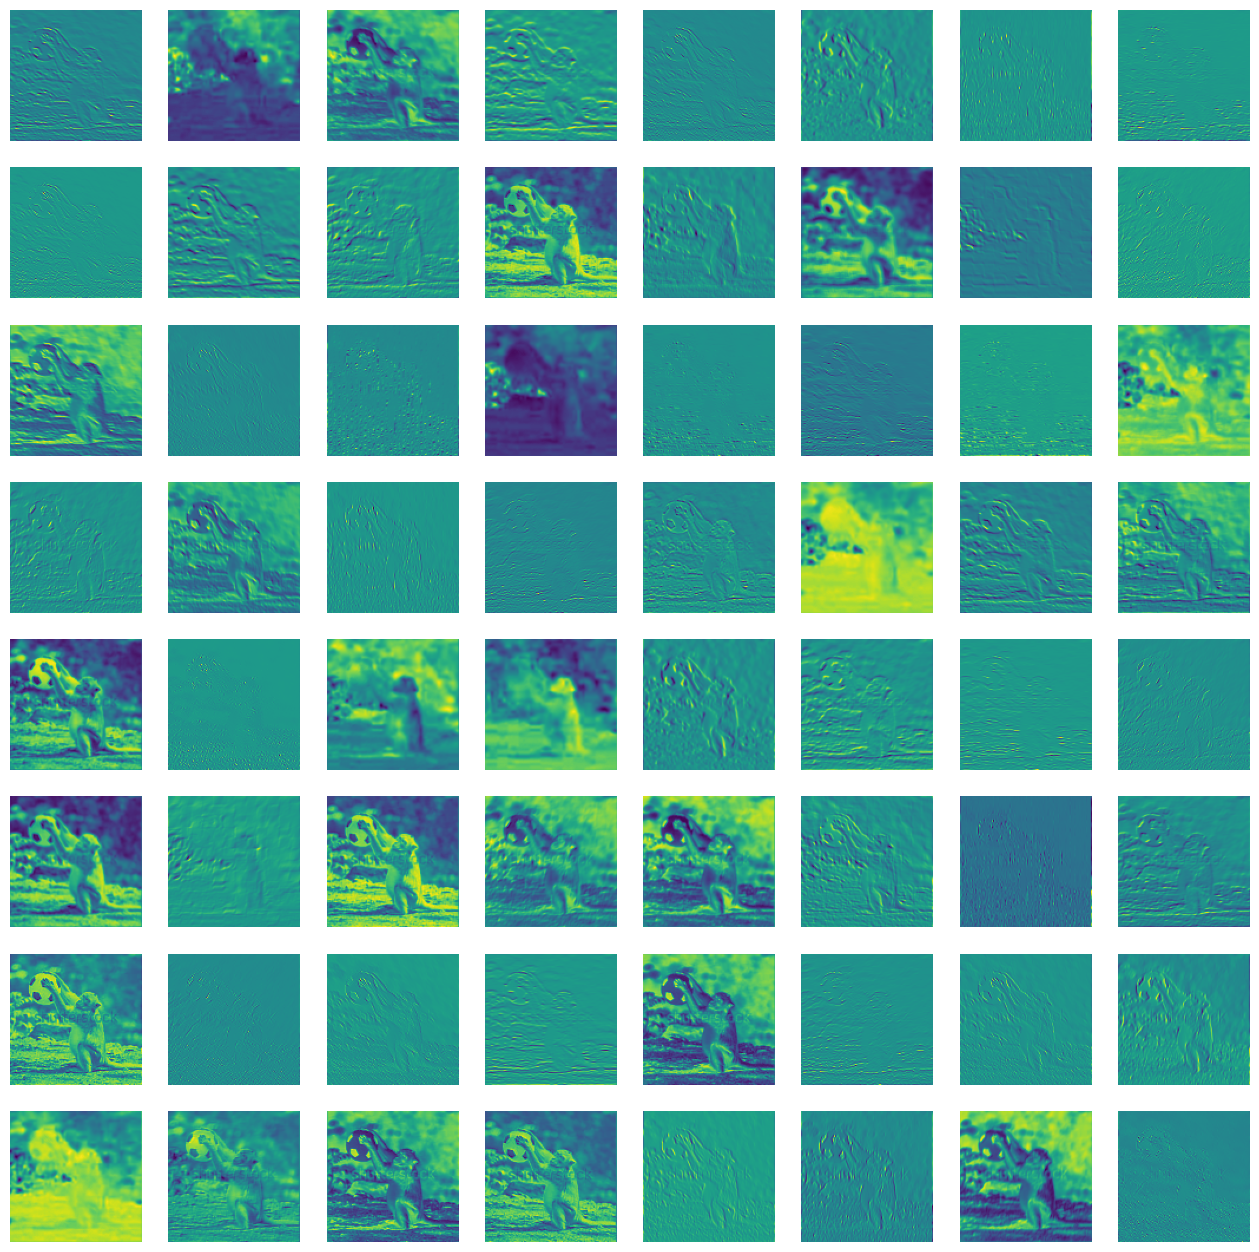

In [16]:
#move image tensor to device
import matplotlib.pyplot as plt
image_tensor = image_tensor.to(device)

#forward pass the image through the encoder
output = image_tensor
feature_maps = []
for name, module in encoder.resnet.named_children():
    output = module(output)
    if isinstance(output, torch.Tensor):
        feature_maps.append(output.clone().detach())

#plot all features maps from the first layer
num_features = feature_maps[0].shape[1] #num of feature maps
fig, axs = plt.subplots(8,8,figsize=(16,16))

for i in range(8):
    for j in range(8):
        feature_map = feature_maps[0][0, i*8+j].cpu().numpy()
        axs[i, j].imshow(feature_map, cmap="viridis")
        axs[i,j].axis("off")

plt.show()